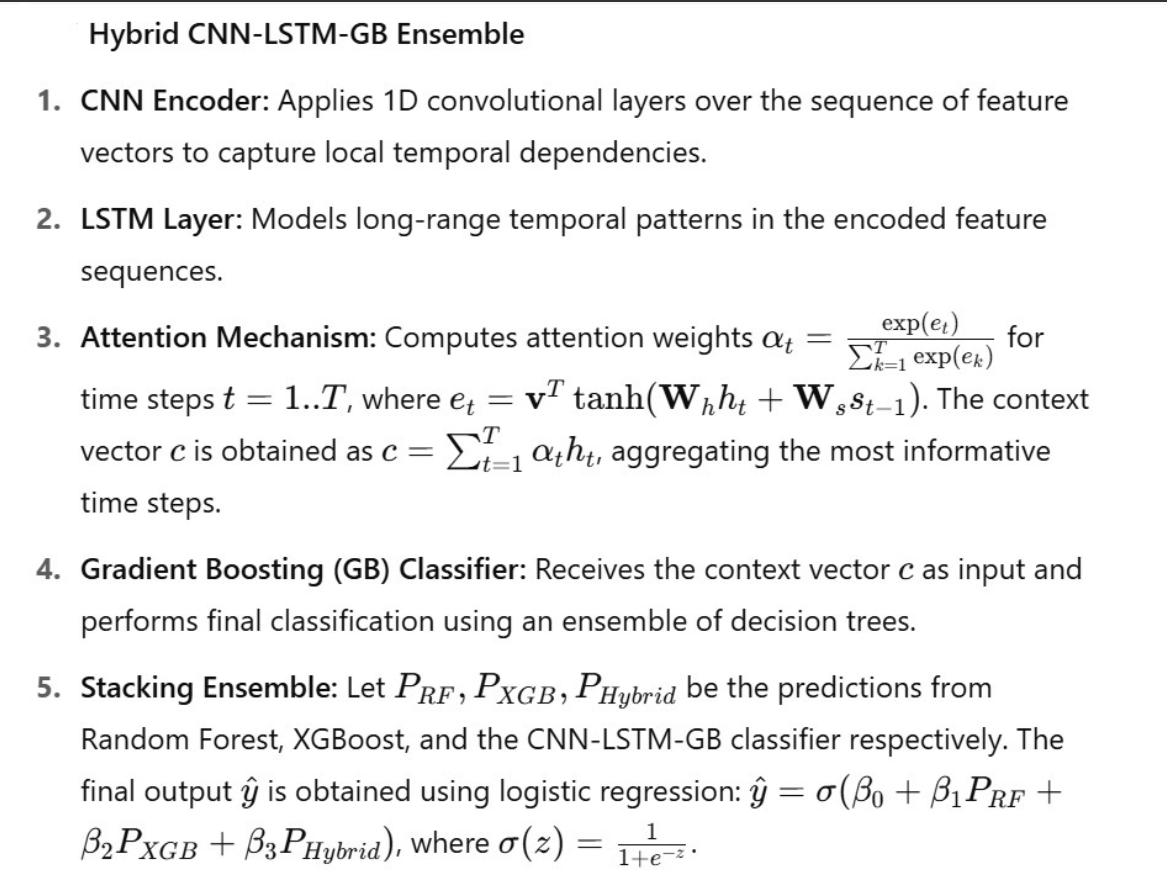

In [1]:
import math 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

### **1. CNN Layer** 
This module helps identify the local (short range) temporal dependencies.\
\
Considering that the dependencies are local, we use a **smaller kernel** size (3 or 5) and also use a stride = 1, which ensures that **no data is lost** while moving the kernel.\
\
We make use of the differentiator kernel [1, 0 -1] which predicts the trends within the sequential data. \
\
Padding = 1 ensures that the shape is maintained, the only problem is the last element will be exceptionally large or exceptionally small due to the edge effect of padding.\
\
We dont necessarily need any bias as we are trying to just find temporal patterns, not get the exact values.\
\
Expected Input Shape = [batch size, 1, sequence length]

In [ ]:
def ConvLayer(X):
    conv = nn.Conv1d(in_channels=1, out_channels=1,
                     kernel_size=3, stride=1,
                     padding=1, bias=False)                                # Takes input of shape [1, 1, x]
    
    conv.weight.data = torch.tensor([[[1.0, 0.0, -1.0]]])                  # Shape [1, 1, 3]
    return conv(X)                                                         # Gives output of shape [1, 1, x]     (Because padding = 1)

In [ ]:
# x = torch.tensor([[[1,2,3,4,5,6,7,8,9,10]]], dtype=torch.float32)           # Shape [1, 1, 10]
# x = ConvLayer(x)
# print(x)                                                                    # [[[-2., -2., -2., -2., -2., -2., -2., -2., -2.,  9.]]]

### **2. LSTM Layer**
This module helps identify the general (long range) temporal dependencies\
\
The nn.lstm we use is as follows : 

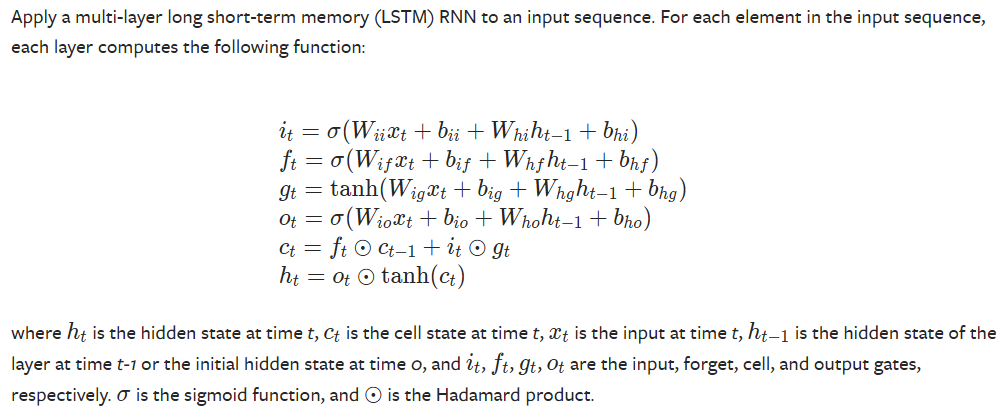

The expected input shape is [batch size, 1, sequence len]. This is then transformed to [sequence len, batch size, 1] which is the required input shape for nn.LSTM\
\
After passing the data, the LSTM returns two useful values, one being the 'output' and another being the 'h_n'.\
\
The **'h_n' vector acts as a summary of the entire sequence**, i.e, the long term representation. Whereas the **output acts as an overall Long and Short term summary for the same**. 


In [47]:
def LSTMLayer(X, hidden_size = 256, num_layers = 1):

    X = X.permute(2, 0, 1)                                  # [batch, 1, seq] --> [seq, batch, 1]
    lstm = nn.LSTM(input_size = 1, hidden_size = hidden_size,
                   num_layers = num_layers, bias = False)
    
    output, (h_n, c_n) = lstm(X)                            # output : [seq, , hidden], h_n = [1, batch, hidden], c_n = [1, batch, hidden]

    return output, (h_n, c_n)   
    

In [ ]:
# X = torch.tensor([[[1,2,3,4,5,6,7,8,9,10]]], dtype=torch.float32)
# op, (h, c) = LSTMLayer(X, 10)
# print(h)

### **3. Bahdanau Attention Mechanism**